# Импорты

Импорт всех необходимых библиотек

In [122]:
%pip install -q catboost
%pip install -q optuna


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [123]:
%pip install -q shap


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from shap import TreeExplainer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [125]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

In [126]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import RandomSampler, TPESampler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
import catboost

In [127]:
import warnings
warnings.filterwarnings("ignore")

Импорт датасета

In [128]:
df = pd.read_csv('db_subset.csv')
df

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13.19,0.02,7.10,295.28,7.91,2.22,1.99,12.16,142.43,7.68,2.35,48.00,13.78,35.43,330.24,372.68,6.19,9.96,2.34,8.96,16.95,254.15,179.18,6.91,24.05,1,0,0,1,59.519091,1
2882,19.9,47.5,27.9,356.44,33.42,3321.43,115.59,2744.22,2027.59,34.25,17.10,103.58,5.77,4.63,26.87,42.02,5027.29,36.82,2.78,134.74,875.24,28.08,3.20,116.85,4.18,252.72,14.96,500.51,26.21,1060.56,2.15,2.15,6.73,3.05,417.65,6.31,185.98,141.09,0.33,7.05,1565.

<Axes: ylabel='Count'>

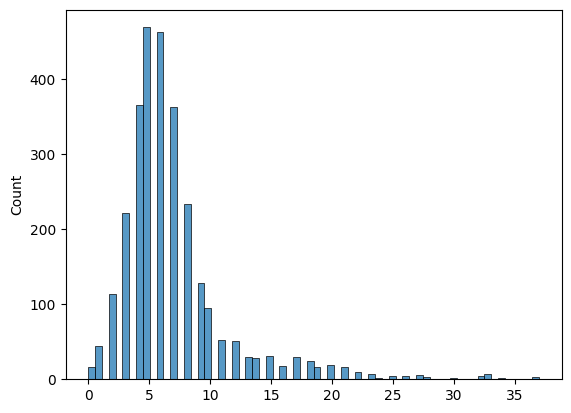

In [129]:
missing_features = df.isnull().sum(axis=1)
sns.histplot(missing_features)

# Предобработка датасета

Все признаки имеют числовой вид, посмотрим на распределение классов

In [130]:
df = df.drop(df[df['bmi']>80].index)

In [131]:
df.loc[df['target'] == 0]['target'].count(), df.loc[df['target'] == 1]['target'].count()

(1871, 1011)

<Axes: xlabel='target', ylabel='Count'>

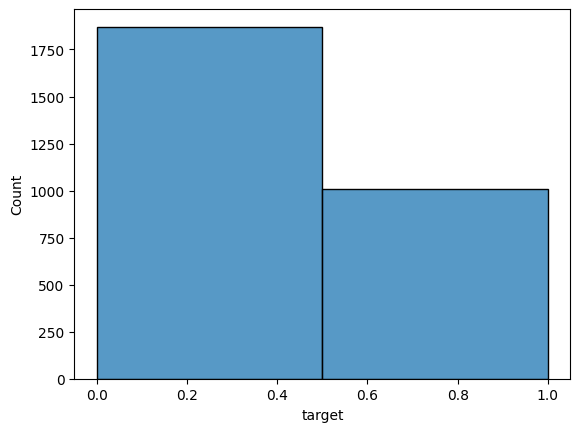

In [132]:
sns.histplot(df['target'], bins = 2)

Классы находятся в соотношении 2:1, будем считать, что они сбалансированы.

Теперь посмотрим на признаки объектов:

In [133]:
df.columns, len(df.columns)

(Index(['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_

Поделим датасет на тренировочную и тестовую выборки, отнормируем их, а затем уже попробуем выбрать наиболее значимые признаки.

<Axes: xlabel='bmi', ylabel='Count'>

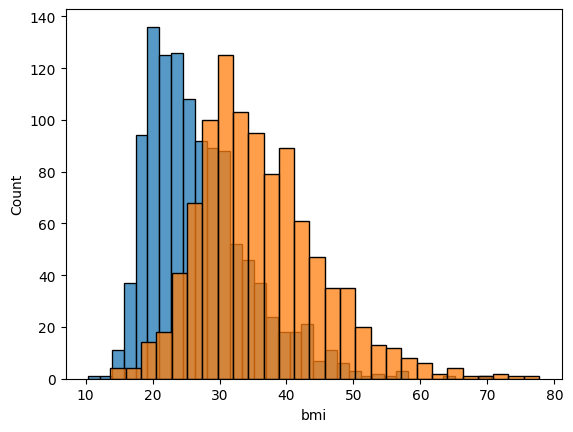

In [134]:
sns.histplot(df[df['target']==0]['bmi'], legend=True)
sns.histplot(df[df['target']==1]['bmi'], legend=True)

In [135]:
df_test = pd.concat([df[df['bmi']<35][df['bmi']>25][df['target']==0].sample(n=216),
                    df[df['bmi']<35][df['bmi']>25][df['target']==1].sample(n=216)])
df_test

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
745,NaN,NaN,NaN,639.65,44.91,2699.49,139.48,2767.01,2558.55,18.33,21.83,76.92,2.19,2.34,17.85,22.48,3657.42,74.27,1.02,115.64,971.02,16.69,NaN,7.72,1.83,331.59,20.60,347.31,9.42,636.33,1.16,2.10,4.14,1.62,315.74,1.36,404.67,132.68,NaN,3.08,1479.19,1.19,NaN,0.97,13.50,14.33,0.01,1.67,120.28,1.70,2.67,0.49,14.34,NaN,1.91,0.61,NaN,3.15,15.73,4.99,2.54,3.36,3.14,0.92,8.11,20.81,85.51,278.53,5.30,4.67,1,0,1,0,30.273880,0
2425,NaN,52.4,NaN,578.77,73.46,6830.65,77.29,3812.74,1783.04,35.90,39.83,145.95,5.70,5.21,30.82,33.18,4099.31,76.99,2.81,193.14,1178.54,10.66,1.60,148.63,4.33,363.51,35.55,462.80,9.56,1143.11,2.89,2.71,5.84,2.11,566.51,6.08,215.73,186.00,0.08,7.57,2038.91,2.50,NaN,2.45,28.55,15.97,0.04,3.92,123.09,4.16,1.52,1.23,20.29,NaN,4.16,5.97,16.0,7.30,35.91,7.60,19.31,19.28,5.44,1.85,16.70,33.56,151.27,234.71,14.86,14.15,1,0,0,1,29.939033,0
2811,20.2,72.0,45.3,759.29,43.55,1811.64,80.46,2600.90,1890.78,25.40,34.88,145.00,7.36,5.23,18.23,27.80,3851.70,30.48,2.83,133.33,1230.24,12.33,0.60,56.31,4.71,191.70,32.13,488.05,20.65,833.41,1.14,2.69,6.55,2.04,291.25,3.19,331.60,31.00,0.08,7.88,1933.64,1.60,0.01,2.44,21.39,23.19,0.12,3.79,133.08,4.23,2.38,1.19,27.01,NaN,4.46,4.48,40.0,7.85,21.84,8.67,19.58,27.03,3.85,2.07,29.62,60.27,162.71,143.27,20.84,14.38,1,0,0,0,29.263340,0
895,NaN,NaN,NaN,200.06,32.51,2117.43,33.65,1111.69,733.83,8.04,14.50,86.80,2.28,2.04,11.76,5.52,1811.94,5.38,1.18,69.61,603.18,NaN,0.15,20.11,1.70,77.91,13.17,195.25,4.59,615.62,0.77,1.43,1.76,0.86,123.05,2.96,50.79,252.67,NaN,2.95,1045.40,0.83,NaN,1.03,8.22,5.16,0.00,1.54,39.48,1.73,0.23,0.44,3.44,NaN,1.62,0.76,30.0,2.94,10.76,3.31,60.69,3.92,0.89,0.53,6.54,16.63,45.37,48.48,5.14,4.44,0,1,1,0,26.528510,0
2858,NaN,43.5,NaN,679.10,44.60,1502.64,95.58,2180.76,1493.72,12.00,22.45,110.39,6.51,4.99,13.11,24.82,3045.04,13.78,2.76,117.29,663.80,1.29,0.20,19.29,4.55,167.42,19.21,267.36,6.36,586.61,0.99,1.80,5.32,1.55,222.72,3.32,130.85,31.00,0.08,7.39,1381.15,1.92,0.01,2.58,15.44,13.17,0.02,3.77,106.41,4.10,1.16,1.07,10.53,69.97,3.87,1.30,16.0,7.27,18.33,230.01,109.50,9.34,3.11,1.13,11.18,25.06,137.33,72.27,7.61,12.29,0,0,0,0,34.804405,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,NaN,NaN,NaN,459.21,43.30,2465.65,116.03,2001.58,2101.81,25.18,10.22,90.66,2.12,1.52,21.11,9.11,3532.92,28.27,0.71,94.21,2235.42,0.54,0.80,56.43,1.27,216.21,9.73,454.02,8.76,1058.15,1.19,2.03,4.05,1.79,269.07,2.10,171.50,0.01,0.12,2.19,1849.44,0.73,NaN,0.62,13.36,6.90,0.01,1.07,256.50,1.13,0.93,0.36,13.11,NaN,1.40,2.16,120.0,2.29,11.24,5.90,130.41,10.53,4.23,1.08,12.42,30.94,58.94,121.05,10.60,4.57,0,1,1,0,28.222222,1
1893,NaN,53.0,NaN,669.72,38.53,4138.65,57.54,2808.61,1415.31,29.50,29.53,164.64,8.91,7.26,27.46,32.81,4549.22,58.10,4.25,114.61,996.02,NaN,1.20,113.19,6.54,252.81,25.79,464.71,5.05,557.07,2.69,3.05,10.43,3.86,501.31,11.47,294.23,31.00,NaN,11.05,2168.35,6.01,0.00,3.67,28.15,13.76,0.

In [136]:
df_train = df.drop(df_test.index)
df_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13.19,0.02,7.10,295.28,7.91,2.22,1.99,12.16,142.43,7.68,2.35,48.00,13.78,35.43,330.24,372.68,6.19,9.96,2.34,8.96,16.95,254.15,179.18,6.91,24.05,1,0,0,1,59.519091,1
2882,19.9,47.5,27.9,356.44,33.42,3321.43,115.59,2744.22,2027.59,34.25,17.10,103.58,5.77,4.63,26.87,42.02,5027.29,36.82,2.78,134.74,875.24,28.08,3.20,116.85,4.18,252.72,14.96,500.51,26.21,1060.56,2.15,2.15,6.73,3.05,417.65,6.31,185.98,141.09,0.33,7.05,1565.

In [137]:
x_train = df_train.drop(columns=['target'])
y_train = df_train['target']

In [138]:
x_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [139]:
column_names = x_train.columns

In [140]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))

In [141]:
column_dict = {a: column_names[a] for a in range(len(x_train.columns))}
column_dict

{0: 'внутриклеточная_жидкость',
 1: 'тощая_мт',
 2: 'акм',
 3: 'холестерин',
 4: 'нас._жир',
 5: 'натрий_na',
 6: 'сахара',
 7: 'энергия',
 8: 'вода',
 9: 'пищ._волокна',
 10: 'мононенас._жир',
 11: 'белки',
 12: 'аргинин',
 13: 'валин',
 14: 'зола',
 15: 'полиненас._жир',
 16: 'калий_k',
 17: 'крахмал',
 18: 'гистидин',
 19: 'жиры',
 20: 'кальций_ca',
 21: 'алкоголь',
 22: 'кремний_si',
 23: 'сера_s',
 24: 'изолейцин',
 25: 'углеводы',
 26: 'олеиновая_кислота',
 27: 'магний_mg',
 28: 'фруктоза',
 29: 'a',
 30: 'b1_тиамин',
 31: 'b2_рибофлав.',
 32: 'b5_пантотен._кис.',
 33: 'b6_пиридоксин',
 34: 'b9_фолаты',
 35: 'b12_кобаламин',
 36: 'b4_холин',
 37: 'β-каротин',
 38: 'ретин._эквив.',
 39: 'лейцин',
 40: 'фосфор_p',
 41: 'омега-3',
 42: 'лактоза',
 43: 'метионин',
 44: 'железо_fe',
 45: 'омега-6',
 46: 'галактоза',
 47: 'метионин+цистеин',
 48: 'c',
 49: 'треонин',
 50: 'd',
 51: 'триптофан',
 52: 'e_α-токоферол',
 53: 'гамма-линолен._к-та',
 54: 'фенилаланин',
 55: 'h_биотин',
 56: 

In [142]:
x_train = x_train.rename(columns=column_dict)
x_test = x_test.rename(columns=column_dict)
x_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi
0,NaN,NaN,NaN,NaN,-1.283871,-1.171953,-0.860554,-1.322459,-1.058445,-1.021644,-1.102513,-1.389227,NaN,NaN,-1.379256,-0.947357,-1.158292,NaN,NaN,-1.319583,-1.067427,-0.278651,NaN,NaN,NaN,-1.111625,-1.077395,-1.181637,NaN,-0.778167,-1.063424,-1.395837,-1.244113,-1.350155,-1.154253,NaN,NaN,NaN,NaN,NaN,-1.423976,-1.092399,NaN,NaN,-1.238943,-0.934137,NaN,NaN,-0.420950,NaN,NaN,NaN,-0.869261,NaN,NaN,NaN,NaN,NaN,-1.368052,NaN,NaN,NaN,-0.880274,-1.050828,NaN,NaN,-1.419679,NaN,NaN,-1.239316,-0.919173,-0.27735,-0.460078,-0.675721,NaN
1,NaN,NaN,NaN,NaN,-1.284626,-1.172085,-0.956013,-1.354878,-0.805180,-1.037084,-1.103607,-1.393371,NaN,NaN,-1.387748,-0.948920,-1.178000,NaN,NaN,-1.321353,-1.072375,-0.331951,NaN,NaN,NaN,-1.166482,-1.078582,-1.193918,NaN,-0.781033,-1.077723,-1.388168,-1.238889,-1.364866,-1.169901,NaN,NaN,NaN,NaN,NaN,-1.431956,-1.098846,NaN,NaN,-1.255327,-0.935872,NaN,NaN,-0.502016,NaN,NaN,NaN,-0.871123,NaN,NaN,NaN,NaN,NaN,-1.359669,NaN,NaN,NaN,-0.783426,-1.050828,NaN,NaN,-1.419242,NaN,NaN,-1.241722,-0.919173,-0.27735,-0.460078,-0.675721,NaN
2,NaN,NaN,NaN,NaN,-1.283871,-1.165727,-0.875649,-1.310251,-1.191650,-1.012381,-1.102513,-1.386465,NaN,NaN,-1.359957,-0.947357,-1.167040,NaN,NaN,-1.319311,-1.059987,-0.176120,NaN,NaN,NaN,-1.110147,-1.077395,-1.171765,NaN,-0.777423,-1.056274,-1.411175,-1.246725,-1.342800,-1.202805,NaN,NaN,NaN,NaN,NaN,-1.422676,-1.092399,NaN,NaN,-1.238260,-0.934137,NaN,NaN,-0.407898,NaN,NaN,NaN,-0.869261,NaN,NaN,NaN,NaN,NaN,-1.346395,NaN,NaN,NaN,-0.996070,-1.058731,NaN,NaN,-1.418079,NaN,NaN,-1.228487,1.087934,-0.27735,-0.460078,-0.675721,NaN
3,NaN,NaN,NaN,-1.191392,-1.283117,-1.174771,NaN,-1.403522,-1.599348,NaN,-1.103060,-1.401351,-1.336117,-1.376046,-1.435609,-0.951003,-1.296689,NaN,-1.317349,-1.320945,-1.091990,NaN,NaN,NaN,-1.371277,NaN,-1.078582,-1.273278,NaN,-0.785314,-1.106322,-1.434182,-1.251949,-1.379576,-1.367152,-0.956325,-1.205010,NaN,NaN,-1.357400,-1.457580,-1.105294,NaN,-1.324151,-1.286730,-0.938474,NaN,-1.360524,NaN,-1.360322,-0.395107,-1.374522,-0.874226,NaN,-1.393180,NaN,NaN,-1.374036,-1.391805,NaN,-0.829938,NaN,-1.019229,-1.137759,NaN,NaN,-1.420261,NaN,NaN,-1.256161,-0.919173,-0.27735,-0.460078,-0.675721,NaN
4,NaN,NaN,NaN,-1.190023,-1.283494,-1.176084,NaN,-1.403091,-1.598671,NaN,-1.101967,-1.398435,-1.329485,-1.371751,-1.435609,-0.951524,-1.295394,NaN,-1.310072,-1.322578,-1.091891,NaN,NaN,NaN,-1.366417,NaN,-1.076801,-1.272556,NaN,-0.785252,-1.106322,-1.434182,-1.251949,-1.379576,-1.366804,-0.952026,-1.202409,NaN,NaN,-1.348912,-1.455635,-1.105294,NaN,-1.315428,-1.284682,-0.939342,NaN,-1.354749,NaN,-1.355142,NaN,-1.355833,-0.874226,NaN,-1.387939,NaN,NaN,-1.368186,-1.389709,NaN,-0.829848,-0.785953,-1.019229,-1.137759,NaN,NaN,-1.418952,NaN,NaN,-1.250145,-0.919173,-0.27735,-0.460078,-0.675721,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,0.289494,0.649150,0.783854,-0.004255,-0.361096,-0.410049,-0.209876,-0.5

Видно, что в датасете есть утечки данных (значения NaN), классический Random Forest Classifier из sklearn.ensemble не может работать с такими данными, поэтому есть несколько вариантов дальнейшей работы:


1.   Работать с моделями, которые поддерживают работу с пропусками в данных
2.   Устранить пропуски при помощи Imputer-а, и обработать его классическим RF

Причем поиск оптимальных параметров для RF будет производиться при помощи GridSearchCV



## Отбор признаков ADD-DEL

In [143]:
sfs = SequentialFeatureSelector(
    XGBClassifier(),  # represents the classifier
    k_features=5,
    forward=True,
    floating=True,
    scoring="f1_macro",  # means that the selection will be decided by the accuracy of the classifier.
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
)

sfs.fit(x_train, y_train)

SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                          estimator=XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, gpu_id=None,
                                                  grow_policy=None,
                                                  importance_...
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_estimators=100, n_jobs=None,
                                                  num_parallel_tree=None,
                                                  predictor=None,
                                                  random_state=None, ...),
                          floating=True, k_features=(5, 5), scoring='f1_macro')

In [144]:
df_temp = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
features_add_del = list(df_temp["feature_idx"].values[-1])
features_add_del

[19, 25, 38, 44, 74]

Для дальнейшей работы возьмем данные 5 наиболее значимых признаков.

In [145]:
x_train_add_del = x_train.iloc[:,features_add_del]
x_test_add_del = x_test.iloc[:,features_add_del]
x_test_add_del.columns

Index(['жиры', 'углеводы', 'ретин._эквив.', 'железо_fe', 'bmi'], dtype='object')

<Axes: ylabel='Count'>

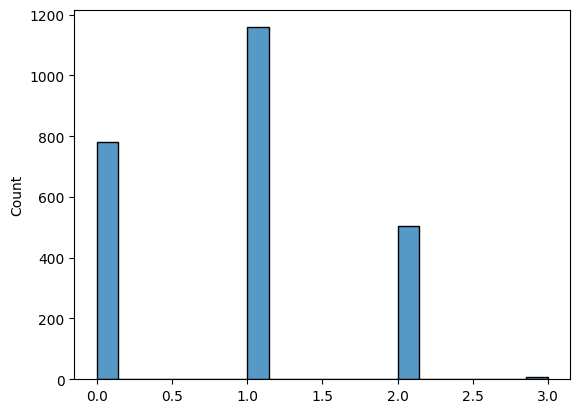

In [146]:
missing_features_add_del = x_train_add_del.isnull().sum(axis=1)
sns.histplot(missing_features_add_del)

## Отбор признаков Boruta

In [147]:
%pip install -q boruta


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [148]:
from boruta import BorutaPy

In [149]:
np.int = np.int64
np.float = np.float64
np.bool = np.bool_

In [150]:
it_imp = IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train)
x_test_imp = it_imp.transform(x_test)

In [151]:
model = XGBClassifier()
feat_selector = BorutaPy(model, n_estimators=100, verbose=1, random_state=42)
feat_selector.fit(x_train_imp, y_train)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

BorutaPy(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None, gpu_id=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 n_estimators=100, n_jobs=None,
                                 num_parallel_tree=None, predictor=None,
                                 random_state=1191989550, ...),
         n_estimators=100, random_state=RandomState(MT19937) at 0x7FCE72705740,
         verbose=1)

In [152]:
keep = x_train.columns[feat_selector.support_].to_list()
normal = x_train.columns[feat_selector.support_weak_].to_list()
drop = x_train.columns[
    ~(feat_selector.support_ | feat_selector.support_weak_)
].to_list()

print("features keep:", keep)
print("features normal:", normal)
print("features drop:", drop)

features keep: ['метионин', 'профессия_работники_преимущественно_умственного_труда', 'профессия_работники_занятые_легким_физическим_трудом', 'спорт_легкий_спорт', 'спорт_не_занимаюсь', 'bmi']
features normal: ['галактоза']
features drop: ['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир', 'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна', 'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир', 'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь', 'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота', 'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.', 'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин', 'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p', 'омега-3', 'лактоза', 'железо_fe', 'омега-6', 'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол', 'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b', 'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йо

In [153]:
keep_ind = pd.DataFrame(x_train_imp).columns[feat_selector.support_].to_list()

## Финальный набор признаков

In [154]:
result = [i for i in x_test_add_del.columns if i in keep]
result

['bmi']

In [155]:
features_selected = list(set([*keep, *x_test_add_del.columns]))
features_selected

['жиры',
 'углеводы',
 'спорт_не_занимаюсь',
 'железо_fe',
 'профессия_работники_занятые_легким_физическим_трудом',
 'bmi',
 'ретин._эквив.',
 'спорт_легкий_спорт',
 'профессия_работники_преимущественно_умственного_труда',
 'метионин']

Убираем из признаков ИМТ

In [156]:
features_selected.remove('bmi')
features_selected

['жиры',
 'углеводы',
 'спорт_не_занимаюсь',
 'железо_fe',
 'профессия_работники_занятые_легким_физическим_трудом',
 'ретин._эквив.',
 'спорт_легкий_спорт',
 'профессия_работники_преимущественно_умственного_труда',
 'метионин']

In [157]:
features_selected_indx = []
for i in features_selected: features_selected_indx.append(list(x_train.columns).index(i))
features_selected_indx = sorted(features_selected_indx)
features_selected_indx

[19, 25, 38, 43, 44, 70, 71, 72, 73]

In [158]:
x_train_selected = x_train.iloc[:,features_selected_indx]
x_test_selected = x_test.iloc[:,features_selected_indx]

<Axes: ylabel='Count'>

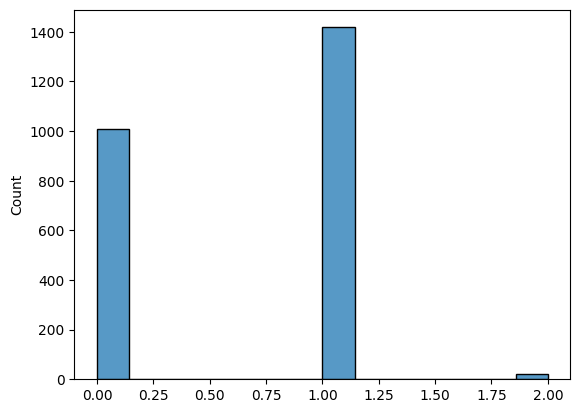

In [159]:
missing_features_selected = x_train_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

<Axes: ylabel='Count'>

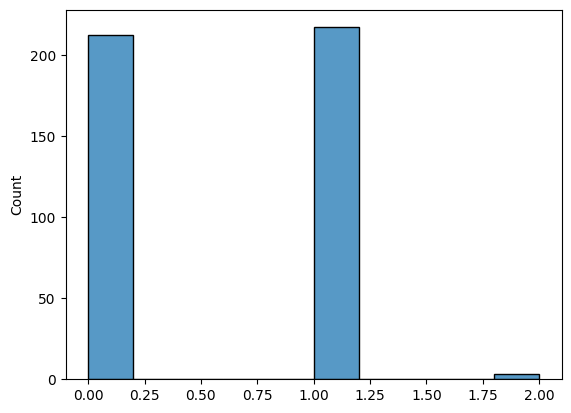

In [160]:
missing_features_selected = x_test_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

Видно, что в тренировочной и тестовой выборках с отобранными 9 параметрами, подавляющее большинство строк имеют 6 значимых признаков и более. Соответственно, на отобранных данных можн проводить обучение.

# Обучение моделей

Для работы с моделями будет использоваться алгоритм кросс-валидации для проверки значений метрик на тренировочной выборке, а итоговые значения метрик будут получаться на тестовой выборке.

Подбор оптимальных параметров происходит при помощи Optuna.

## 1. Рандомный лес

### 1. Imputer + RandomForest

In [161]:
it_imp = SimpleImputer(missing_values=np.nan, strategy='mean') #IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train)
x_test_imp = it_imp.transform(x_test)

In [162]:
def param_search_rf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1)
    }

    model = RandomForestClassifier(**params)
    model.fit(x_train_imp, y_train)
    predictions = model.predict(x_test_imp)
    return f1_score(y_test, predictions)

In [163]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(param_search_rf, n_trials=30)

[I 2024-11-11 10:30:36,850] A new study created in memory with name: no-name-1fe87a15-1dcd-4f53-adb2-7f715f7cb2e6
[I 2024-11-11 10:30:39,457] Trial 0 finished with value: 0.3487544483985765 and parameters: {'max_depth': 3, 'n_estimators': 500, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.3487544483985765.
[I 2024-11-11 10:30:42,342] Trial 1 finished with value: 0.4220779220779221 and parameters: {'max_depth': 7, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.4220779220779221.
[I 2024-11-11 10:30:43,409] Trial 2 finished with value: 0.43729903536977494 and parameters: {'max_depth': 8, 'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.43729903536977494.
[I 2024-11-11 10:30:44,177] Trial 3 finished with value: 0.41935483870967744 and parameters: {'max_depth': 5, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 2 with valu

In [164]:
print('Best hyperparameters:', study_rf.best_params)
print('Best ROC-AUC score:', study_rf.best_value)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 2}
Best ROC-AUC score: 0.48000000000000004


In [165]:
rfc_best = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                  max_depth = study_rf.best_params['max_depth'],
                                  min_samples_split = study_rf.best_params['min_samples_split'],
                                  min_samples_leaf = study_rf.best_params['min_samples_leaf'],
                                  criterion='log_loss')
rfc_best.fit(x_train_imp, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=10, min_samples_leaf=2,
                       min_samples_split=4, n_estimators=400)

Метрики, получаемые из кросс-валидации

In [166]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(rfc_best, x_train_imp, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([3.6974895 , 3.72426581, 3.67491651, 3.61215758, 3.59379268]),
 'score_time': array([0.06632209, 0.0726614 , 0.0725348 , 0.07206488, 0.07281423]),
 'test_accuracy': array([0.73673469, 0.80816327, 0.83061224, 0.79795918, 0.75510204]),
 'test_precision_macro': array([0.83133385, 0.79232877, 0.81381752, 0.76940994, 0.72952652]),
 'test_recall_macro': array([0.59760778, 0.75342492, 0.78965019, 0.77691957, 0.75173383]),
 'test_f1_macro': array([0.58384631, 0.76697831, 0.79950801, 0.77281987, 0.73530683]),
 'test_roc_auc': array([0.89746148, 0.89205571, 0.89710996, 0.84860058, 0.83596496])}

In [167]:
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

In [168]:
def f2_score_on_pr_rec(precision, recall):
  return (5*precision*recall)/(4*precision+recall)

In [169]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
rfc_best_cv_metrics = []
for metric in metrics: rfc_best_cv_metrics.append(scores[metric])
rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
rfc_best_cv_metrics = np.array(rfc_best_cv_metrics)

In [170]:
def report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred, normalize="all")
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, cmap="Reds")
  print("F2-score: ", f2_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.84      0.68       216
           1       0.69      0.35      0.47       216

    accuracy                           0.60       432
   macro avg       0.63      0.60      0.57       432
weighted avg       0.63      0.60      0.57       432

F2-score:  0.39014373716632444


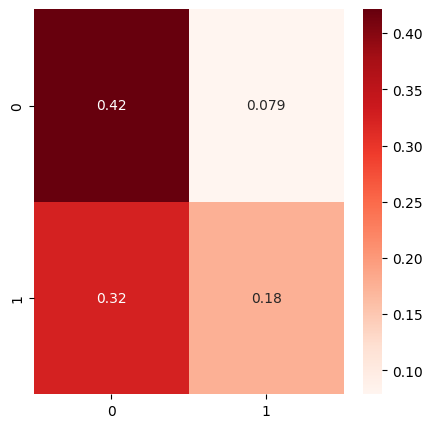

In [171]:
report(y_test, rfc_best.predict(x_test_imp))

### 2. XGBRFClassifier

In [172]:
def param_search_xgbrf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
    }

    model = XGBRFClassifier(**params)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [173]:
study_xgbrf = optuna.create_study(direction='maximize')
study_xgbrf.optimize(param_search_xgbrf, n_trials=30)

[I 2024-11-11 10:32:51,963] A new study created in memory with name: no-name-d65a2ab4-0310-4216-b13c-9689c25377f0


[10:32:52] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:32:53,112] Trial 0 finished with value: 0.4254143646408839 and parameters: {'max_depth': 6, 'n_estimators': 600}. Best is trial 0 with value: 0.4254143646408839.


[10:32:53] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:32:53,847] Trial 1 finished with value: 0.4101123595505618 and parameters: {'max_depth': 5, 'n_estimators': 500}. Best is trial 0 with value: 0.4254143646408839.


[10:32:53] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:32:54,314] Trial 2 finished with value: 0.41551246537396125 and parameters: {'max_depth': 7, 'n_estimators': 200}. Best is trial 0 with value: 0.4254143646408839.


[10:32:54] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:32:55,315] Trial 3 finished with value: 0.38953488372093026 and parameters: {'max_depth': 4, 'n_estimators': 900}. Best is trial 0 with value: 0.4254143646408839.


[10:32:55] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:32:56,122] Trial 4 finished with value: 0.40782122905027934 and parameters: {'max_depth': 8, 'n_estimators': 300}. Best is trial 0 with value: 0.4254143646408839.


[10:32:56] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:32:56,215] Trial 5 finished with value: 0.3679525222551928 and parameters: {'max_depth': 3, 'n_estimators': 100}. Best is trial 0 with value: 0.4254143646408839.


[10:32:56] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:32:57,220] Trial 6 finished with value: 0.4112676056338028 and parameters: {'max_depth': 5, 'n_estimators': 700}. Best is trial 0 with value: 0.4254143646408839.


[10:32:57] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:32:57,724] Trial 7 finished with value: 0.3679525222551928 and parameters: {'max_depth': 3, 'n_estimators': 600}. Best is trial 0 with value: 0.4254143646408839.


[10:32:57] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:32:59,864] Trial 8 finished with value: 0.40782122905027934 and parameters: {'max_depth': 8, 'n_estimators': 800}. Best is trial 0 with value: 0.4254143646408839.


[10:32:59] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:02,091] Trial 9 finished with value: 0.4219178082191781 and parameters: {'max_depth': 9, 'n_estimators': 700}. Best is trial 0 with value: 0.4254143646408839.


[10:33:02] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:03,921] Trial 10 finished with value: 0.42134831460674155 and parameters: {'max_depth': 6, 'n_estimators': 1000}. Best is trial 0 with value: 0.4254143646408839.


[10:33:03] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:05,770] Trial 11 finished with value: 0.41734417344173447 and parameters: {'max_depth': 10, 'n_estimators': 500}. Best is trial 0 with value: 0.4254143646408839.


[10:33:05] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:07,242] Trial 12 finished with value: 0.41734417344173447 and parameters: {'max_depth': 10, 'n_estimators': 400}. Best is trial 0 with value: 0.4254143646408839.


[10:33:07] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:09,115] Trial 13 finished with value: 0.40782122905027934 and parameters: {'max_depth': 8, 'n_estimators': 700}. Best is trial 0 with value: 0.4254143646408839.


[10:33:09] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:11,345] Trial 14 finished with value: 0.4219178082191781 and parameters: {'max_depth': 9, 'n_estimators': 700}. Best is trial 0 with value: 0.4254143646408839.


[10:33:11] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:12,974] Trial 15 finished with value: 0.42016806722689076 and parameters: {'max_depth': 6, 'n_estimators': 900}. Best is trial 0 with value: 0.4254143646408839.


[10:33:12] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:14,322] Trial 16 finished with value: 0.4111111111111111 and parameters: {'max_depth': 7, 'n_estimators': 600}. Best is trial 0 with value: 0.4254143646408839.


[10:33:14] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:15,607] Trial 17 finished with value: 0.418732782369146 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 0 with value: 0.4254143646408839.


[10:33:15] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:16,778] Trial 18 finished with value: 0.4101123595505618 and parameters: {'max_depth': 5, 'n_estimators': 800}. Best is trial 0 with value: 0.4254143646408839.


[10:33:16] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:18,057] Trial 19 finished with value: 0.418732782369146 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 0 with value: 0.4254143646408839.


[10:33:18] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:19,848] Trial 20 finished with value: 0.41340782122905034 and parameters: {'max_depth': 7, 'n_estimators': 800}. Best is trial 0 with value: 0.4254143646408839.


[10:33:19] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:22,069] Trial 21 finished with value: 0.4219178082191781 and parameters: {'max_depth': 9, 'n_estimators': 700}. Best is trial 0 with value: 0.4254143646408839.


[10:33:22] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:24,273] Trial 22 finished with value: 0.41621621621621624 and parameters: {'max_depth': 10, 'n_estimators': 600}. Best is trial 0 with value: 0.4254143646408839.


[10:33:24] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:26,162] Trial 23 finished with value: 0.40782122905027934 and parameters: {'max_depth': 8, 'n_estimators': 700}. Best is trial 0 with value: 0.4254143646408839.


[10:33:26] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:27,750] Trial 24 finished with value: 0.4143646408839779 and parameters: {'max_depth': 9, 'n_estimators': 500}. Best is trial 0 with value: 0.4254143646408839.


[10:33:27] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:29,396] Trial 25 finished with value: 0.42016806722689076 and parameters: {'max_depth': 6, 'n_estimators': 900}. Best is trial 0 with value: 0.4254143646408839.


[10:33:29] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:30,755] Trial 26 finished with value: 0.4111111111111111 and parameters: {'max_depth': 7, 'n_estimators': 600}. Best is trial 0 with value: 0.4254143646408839.


[10:33:30] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:33,318] Trial 27 finished with value: 0.4143646408839779 and parameters: {'max_depth': 9, 'n_estimators': 800}. Best is trial 0 with value: 0.4254143646408839.


[10:33:33] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:34,453] Trial 28 finished with value: 0.38953488372093026 and parameters: {'max_depth': 4, 'n_estimators': 1000}. Best is trial 0 with value: 0.4254143646408839.


[10:33:34] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 10:33:35,819] Trial 29 finished with value: 0.4022346368715084 and parameters: {'max_depth': 8, 'n_estimators': 500}. Best is trial 0 with value: 0.4254143646408839.


In [174]:
print('Best hyperparameters:', study_xgbrf.best_params)
print('Best f1 score:', study_xgbrf.best_value)

Best hyperparameters: {'max_depth': 6, 'n_estimators': 600}
Best f1 score: 0.4254143646408839


In [175]:
xgb_rfc_best = XGBRFClassifier(criterion='log_loss', max_depth=study_xgbrf.best_params['max_depth'], n_estimators=study_xgbrf.best_params['n_estimators'])
xgb_rfc_best.fit(x_train_selected, y_train)

[10:33:35] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                criterion='log_loss', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=6, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=600, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None, ...)

In [176]:
scoring = ['accuracy', 'roc_auc','precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(xgb_rfc_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())

[10:33:36] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[10:33:37] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[10:33:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[10:33:39] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[10:33:40] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



['fit_time',
 'score_time',
 'test_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro',
 'test_roc_auc']

In [177]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_rfc_best_cv_metrics = []
for metric in metrics: xgb_rfc_best_cv_metrics.append(scores[metric])
xgb_rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_rfc_best_cv_metrics  = np.array( xgb_rfc_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.51      0.68      0.59       216
           1       0.53      0.36      0.43       216

    accuracy                           0.52       432
   macro avg       0.52      0.52      0.51       432
weighted avg       0.52      0.52      0.51       432

F2-score:  0.3811881188118812


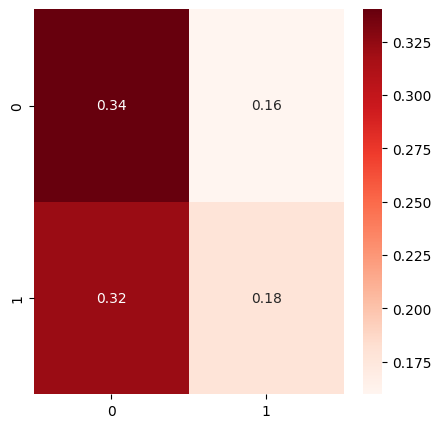

In [178]:
report(y_test, xgb_rfc_best.predict(x_test_selected))

## Бустинги

### Catboost

In [179]:
model = CatBoostClassifier(random_seed=42)

In [180]:
model.fit(
    x_train_selected,
    y_train,
    eval_set=(x_test_selected, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.03954
0:	learn: 0.6787113	test: 0.6929947	best: 0.6929947 (0)	total: 1.8ms	remaining: 1.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6927560622
bestIteration = 1

Shrink model to first 2 iterations.


In [181]:
f1_score(y_test, model.predict(x_test_selected))

0.41551246537396125

In [182]:
model.get_feature_importance(catboost.Pool(x_train_selected))

array([ 0.        ,  6.90139482,  4.8589016 , 42.2911028 ,  4.90656241,
        0.        ,  0.        ,  0.        , 41.04203837])

In [183]:
def param_search_cb(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.)
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [184]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(param_search_cb, n_trials=30)

[I 2024-11-11 10:33:42,056] A new study created in memory with name: no-name-2dd4c96d-0b28-4be7-8916-ed73267850db
[I 2024-11-11 10:33:42,944] Trial 0 finished with value: 0.44505494505494503 and parameters: {'learning_rate': 0.03513170293472713, 'depth': 4, 'subsample': 0.7794855409411608, 'colsample_bylevel': 0.22147509553881217, 'min_data_in_leaf': 99, 'random_strength': 1.9287077400776877}. Best is trial 0 with value: 0.44505494505494503.
[I 2024-11-11 10:33:44,559] Trial 1 finished with value: 0.4273972602739726 and parameters: {'learning_rate': 0.027435941018259823, 'depth': 7, 'subsample': 0.15084630761966844, 'colsample_bylevel': 0.8726601012116924, 'min_data_in_leaf': 34, 'random_strength': 1.3269219416279778}. Best is trial 0 with value: 0.44505494505494503.
[I 2024-11-11 10:33:49,285] Trial 2 finished with value: 0.42253521126760557 and parameters: {'learning_rate': 0.005015080745001544, 'depth': 10, 'subsample': 0.6805414623071143, 'colsample_bylevel': 0.7617792207401762, 'm

In [185]:
print('Best hyperparameters:', study_cb.best_params)
print('Best f1 score:', study_cb.best_value)

Best hyperparameters: {'learning_rate': 0.05951410532279043, 'depth': 6, 'subsample': 0.7096699861709889, 'colsample_bylevel': 0.36115394430849496, 'min_data_in_leaf': 69, 'random_strength': 1.819425378670536}
Best f1 score: 0.4734042553191489


In [186]:
cb_best = CatBoostClassifier(learning_rate=study_cb.best_params['learning_rate'],
                             depth=study_cb.best_params['depth'],
                             random_seed=42,
                             subsample=study_cb.best_params['subsample'],
                             colsample_bylevel=study_cb.best_params['colsample_bylevel'],
                             min_data_in_leaf =study_cb.best_params['min_data_in_leaf'],
                             random_strength=study_cb.best_params['random_strength'])
cb_best.fit(x_train_selected, y_train)

0:	learn: 0.6714282	total: 1.38ms	remaining: 1.38s
1:	learn: 0.6566146	total: 2.75ms	remaining: 1.37s
2:	learn: 0.6406209	total: 3.95ms	remaining: 1.31s
3:	learn: 0.6291821	total: 5.08ms	remaining: 1.26s
4:	learn: 0.6157300	total: 6.39ms	remaining: 1.27s
5:	learn: 0.6074858	total: 7.39ms	remaining: 1.22s
6:	learn: 0.6019910	total: 8.17ms	remaining: 1.16s
7:	learn: 0.5970635	total: 9.01ms	remaining: 1.12s
8:	learn: 0.5935756	total: 9.96ms	remaining: 1.1s
9:	learn: 0.5883149	total: 11.2ms	remaining: 1.11s
10:	learn: 0.5840394	total: 12.3ms	remaining: 1.1s
11:	learn: 0.5774916	total: 13.3ms	remaining: 1.1s
12:	learn: 0.5734113	total: 14.5ms	remaining: 1.1s
13:	learn: 0.5697074	total: 15.6ms	remaining: 1.1s
14:	learn: 0.5666458	total: 16.6ms	remaining: 1.09s
15:	learn: 0.5618637	total: 17.7ms	remaining: 1.09s
16:	learn: 0.5583875	total: 18.4ms	remaining: 1.07s
17:	learn: 0.5571578	total: 19.3ms	remaining: 1.05s
18:	learn: 0.5544619	total: 20.6ms	remaining: 1.06s
19:	learn: 0.5501340	total:

In [187]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(cb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

0:	learn: 0.6722705	total: 1.25ms	remaining: 1.25s
1:	learn: 0.6581194	total: 2.49ms	remaining: 1.24s
2:	learn: 0.6436724	total: 3.59ms	remaining: 1.19s
3:	learn: 0.6312689	total: 4.61ms	remaining: 1.15s
4:	learn: 0.6183279	total: 5.81ms	remaining: 1.16s
5:	learn: 0.6101251	total: 6.86ms	remaining: 1.14s
6:	learn: 0.6002043	total: 7.97ms	remaining: 1.13s
7:	learn: 0.5915829	total: 9.12ms	remaining: 1.13s
8:	learn: 0.5859064	total: 10.3ms	remaining: 1.13s
9:	learn: 0.5780147	total: 11.4ms	remaining: 1.13s
10:	learn: 0.5718290	total: 12.5ms	remaining: 1.12s
11:	learn: 0.5692172	total: 13.1ms	remaining: 1.08s
12:	learn: 0.5618967	total: 14.2ms	remaining: 1.08s
13:	learn: 0.5577089	total: 15.3ms	remaining: 1.08s
14:	learn: 0.5546316	total: 16.3ms	remaining: 1.07s
15:	learn: 0.5531898	total: 17ms	remaining: 1.04s
16:	learn: 0.5514579	total: 17.7ms	remaining: 1.02s
17:	learn: 0.5488508	total: 18.7ms	remaining: 1.02s
18:	learn: 0.5463604	total: 19.6ms	remaining: 1.01s
19:	learn: 0.5431885	tot

{'fit_time': array([1.14143682, 1.15282059, 1.18726516, 1.18791008, 1.18848038]),
 'score_time': array([0.00901508, 0.0082624 , 0.00809002, 0.00799084, 0.0081265 ]),
 'test_accuracy': array([0.71428571, 0.68571429, 0.70816327, 0.66938776, 0.63469388]),
 'test_precision_macro': array([0.75725631, 0.62683983, 0.66004785, 0.63352379, 0.61926852]),
 'test_recall_macro': array([0.56955291, 0.59742727, 0.62711623, 0.64253548, 0.63483061]),
 'test_f1_macro': array([0.54297135, 0.60079143, 0.63363816, 0.63619865, 0.61567617]),
 'test_roc_auc': array([0.76714359, 0.74020027, 0.76148131, 0.68184841, 0.67084687])}

In [188]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
cb_best_cv_metrics = []
for metric in metrics: cb_best_cv_metrics.append(scores[metric])
cb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
cb_best_cv_metrics = np.array(cb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.52      0.63      0.57       216
           1       0.53      0.41      0.46       216

    accuracy                           0.52       432
   macro avg       0.52      0.52      0.52       432
weighted avg       0.52      0.52      0.52       432

F2-score:  0.43078412391093907


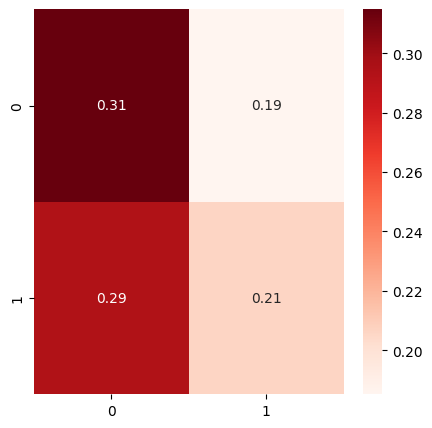

In [189]:
report(y_test, cb_best.predict(x_test_selected))

### XGBoost

In [190]:
model = XGBClassifier()

In [191]:
model.fit(
    x_train_selected,
    y_train,
    )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [192]:
def param_search_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [193]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(param_search_xgb, n_trials=30)

[I 2024-11-11 10:34:34,112] A new study created in memory with name: no-name-3b2a7904-bc6b-4e8e-af56-67d959291362


[10:34:34] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:37,385] Trial 0 finished with value: 0.4277777777777777 and parameters: {'learning_rate': 0.0018490106570033286, 'max_depth': 300, 'n_estimators': 1000, 'subsample': 0.5299520429905534, 'colsample_bylevel': 0.5377121332498851, 'gamma': 0.23450736808605768}. Best is trial 0 with value: 0.4277777777777777.


[10:34:37] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:37,700] Trial 1 finished with value: 0.45212765957446804 and parameters: {'learning_rate': 0.05128368562717347, 'max_depth': 211, 'n_estimators': 300, 'subsample': 0.4096013676305894, 'colsample_bylevel': 0.07942205245713305, 'gamma': 0.9382103053189685}. Best is trial 1 with value: 0.45212765957446804.


[10:34:37] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:38,288] Trial 2 finished with value: 0.46399999999999997 and parameters: {'learning_rate': 0.04535243036983489, 'max_depth': 259, 'n_estimators': 900, 'subsample': 0.11330435374775424, 'colsample_bylevel': 0.08749133889152882, 'gamma': 1.4423149075720727}. Best is trial 2 with value: 0.46399999999999997.


[10:34:38] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:39,237] Trial 3 finished with value: 0.39316239316239315 and parameters: {'learning_rate': 0.012528632692180344, 'max_depth': 321, 'n_estimators': 600, 'subsample': 0.1554868377889796, 'colsample_bylevel': 0.739789998523979, 'gamma': 1.8410736301453037}. Best is trial 2 with value: 0.46399999999999997.


[10:34:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:39,366] Trial 4 finished with value: 0.23239436619718312 and parameters: {'learning_rate': 0.00207716012569077, 'max_depth': 124, 'n_estimators': 100, 'subsample': 0.6241161805849906, 'colsample_bylevel': 0.14874415855786355, 'gamma': 2.0442914015846694}. Best is trial 2 with value: 0.46399999999999997.


[10:34:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:39,468] Trial 5 finished with value: 0.29773462783171517 and parameters: {'learning_rate': 0.01056501133885804, 'max_depth': 340, 'n_estimators': 100, 'subsample': 0.289854781671352, 'colsample_bylevel': 0.19760437598069286, 'gamma': 1.376719662557633}. Best is trial 2 with value: 0.46399999999999997.


[10:34:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:42,201] Trial 6 finished with value: 0.43126684636118595 and parameters: {'learning_rate': 0.01562935491875389, 'max_depth': 471, 'n_estimators': 1000, 'subsample': 0.4523845623100539, 'colsample_bylevel': 0.42752942828259805, 'gamma': 0.22413543144041997}. Best is trial 2 with value: 0.46399999999999997.


[10:34:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:43,299] Trial 7 finished with value: 0.40668523676880225 and parameters: {'learning_rate': 0.0184018247213449, 'max_depth': 403, 'n_estimators': 500, 'subsample': 0.2587656041456843, 'colsample_bylevel': 0.6837515523437291, 'gamma': 0.35815660457523635}. Best is trial 2 with value: 0.46399999999999997.


[10:34:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:45,841] Trial 8 finished with value: 0.41509433962264153 and parameters: {'learning_rate': 0.003894707843149685, 'max_depth': 362, 'n_estimators': 500, 'subsample': 0.794339315015871, 'colsample_bylevel': 0.8642734866678955, 'gamma': 2.233990950858762}. Best is trial 2 with value: 0.46399999999999997.


[10:34:45] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:47,092] Trial 9 finished with value: 0.42245989304812837 and parameters: {'learning_rate': 0.0152866475218482, 'max_depth': 130, 'n_estimators': 200, 'subsample': 0.9417714610872246, 'colsample_bylevel': 0.9938560508269226, 'gamma': 0.5838734263092215}. Best is trial 2 with value: 0.46399999999999997.


[10:34:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:47,805] Trial 10 finished with value: 0.43989769820971864 and parameters: {'learning_rate': 0.08118301114963063, 'max_depth': 235, 'n_estimators': 800, 'subsample': 0.08704527781707139, 'colsample_bylevel': 0.3201069839481854, 'gamma': 1.2940390781737794}. Best is trial 2 with value: 0.46399999999999997.


[10:34:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:48,125] Trial 11 finished with value: 0.4204545454545454 and parameters: {'learning_rate': 0.0695521232089051, 'max_depth': 212, 'n_estimators': 300, 'subsample': 0.34262187647749, 'colsample_bylevel': 0.09420940326357846, 'gamma': 0.9752419501038863}. Best is trial 2 with value: 0.46399999999999997.


[10:34:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:48,640] Trial 12 finished with value: 0.3817663817663817 and parameters: {'learning_rate': 0.03925639077674814, 'max_depth': 208, 'n_estimators': 700, 'subsample': 0.05023101918788864, 'colsample_bylevel': 0.28984085260016446, 'gamma': 2.9509856638024994}. Best is trial 2 with value: 0.46399999999999997.


[10:34:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:49,179] Trial 13 finished with value: 0.4273972602739726 and parameters: {'learning_rate': 0.03519248698492756, 'max_depth': 252, 'n_estimators': 400, 'subsample': 0.6859372852769583, 'colsample_bylevel': 0.060765226245393544, 'gamma': 0.8954987371820496}. Best is trial 2 with value: 0.46399999999999997.


[10:34:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:50,813] Trial 14 finished with value: 0.42780748663101603 and parameters: {'learning_rate': 0.03449635946722234, 'max_depth': 163, 'n_estimators': 800, 'subsample': 0.40235324787687166, 'colsample_bylevel': 0.2659155932519438, 'gamma': 1.6022484215184463}. Best is trial 2 with value: 0.46399999999999997.


[10:34:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:51,364] Trial 15 finished with value: 0.4067796610169491 and parameters: {'learning_rate': 0.005227940705775102, 'max_depth': 290, 'n_estimators': 300, 'subsample': 0.2109757719259278, 'colsample_bylevel': 0.44669692132843647, 'gamma': 0.941253368164218}. Best is trial 2 with value: 0.46399999999999997.


[10:34:51] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:52,326] Trial 16 finished with value: 0.43915343915343913 and parameters: {'learning_rate': 0.09996704222491726, 'max_depth': 179, 'n_estimators': 900, 'subsample': 0.515957037953236, 'colsample_bylevel': 0.20405486835811032, 'gamma': 2.3444158028444884}. Best is trial 2 with value: 0.46399999999999997.


[10:34:52] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:52,813] Trial 17 finished with value: 0.4175824175824176 and parameters: {'learning_rate': 0.04940739892982964, 'max_depth': 275, 'n_estimators': 600, 'subsample': 0.20005746078956266, 'colsample_bylevel': 0.06194503710266288, 'gamma': 1.1963681627089553}. Best is trial 2 with value: 0.46399999999999997.


[10:34:52] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:53,793] Trial 18 finished with value: 0.4273972602739726 and parameters: {'learning_rate': 0.022745161724187803, 'max_depth': 393, 'n_estimators': 400, 'subsample': 0.3531657952591924, 'colsample_bylevel': 0.3730301568117613, 'gamma': 0.6927962522687517}. Best is trial 2 with value: 0.46399999999999997.


[10:34:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:57,230] Trial 19 finished with value: 0.3978201634877384 and parameters: {'learning_rate': 0.0065979735697362495, 'max_depth': 105, 'n_estimators': 700, 'subsample': 0.7354051260260882, 'colsample_bylevel': 0.5710920995370619, 'gamma': 1.6851117728178142}. Best is trial 2 with value: 0.46399999999999997.


[10:34:57] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:57,649] Trial 20 finished with value: 0.2629757785467128 and parameters: {'learning_rate': 0.0011072964712687938, 'max_depth': 177, 'n_estimators': 300, 'subsample': 0.9501147868625306, 'colsample_bylevel': 0.1768185625365375, 'gamma': 2.8238431225943135}. Best is trial 2 with value: 0.46399999999999997.


[10:34:57] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:58,473] Trial 21 finished with value: 0.45623342175066317 and parameters: {'learning_rate': 0.08223607233085824, 'max_depth': 231, 'n_estimators': 800, 'subsample': 0.12494041118815878, 'colsample_bylevel': 0.2953817261719119, 'gamma': 1.3234824997006396}. Best is trial 2 with value: 0.46399999999999997.


[10:34:58] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:34:59,410] Trial 22 finished with value: 0.4456233421750663 and parameters: {'learning_rate': 0.059052172871724276, 'max_depth': 254, 'n_estimators': 900, 'subsample': 0.12673948679863445, 'colsample_bylevel': 0.24799308530082892, 'gamma': 1.2006779900202105}. Best is trial 2 with value: 0.46399999999999997.


[10:34:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:00,124] Trial 23 finished with value: 0.45283018867924535 and parameters: {'learning_rate': 0.02583025882156104, 'max_depth': 211, 'n_estimators': 800, 'subsample': 0.2680118692653851, 'colsample_bylevel': 0.1351372681222355, 'gamma': 1.547927547647442}. Best is trial 2 with value: 0.46399999999999997.


[10:35:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:01,235] Trial 24 finished with value: 0.4216216216216216 and parameters: {'learning_rate': 0.02434883735901076, 'max_depth': 266, 'n_estimators': 800, 'subsample': 0.15123271958352374, 'colsample_bylevel': 0.3546575827077606, 'gamma': 1.9176417362392408}. Best is trial 2 with value: 0.46399999999999997.


[10:35:01] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:02,025] Trial 25 finished with value: 0.46399999999999997 and parameters: {'learning_rate': 0.02731452446749605, 'max_depth': 232, 'n_estimators': 900, 'subsample': 0.2652648153327417, 'colsample_bylevel': 0.16672612580841883, 'gamma': 1.5266676858303836}. Best is trial 2 with value: 0.46399999999999997.


[10:35:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:02,796] Trial 26 finished with value: 0.4583333333333333 and parameters: {'learning_rate': 0.0956633667754424, 'max_depth': 317, 'n_estimators': 900, 'subsample': 0.06547202908189273, 'colsample_bylevel': 0.42526995633469955, 'gamma': 1.480716576316684}. Best is trial 2 with value: 0.46399999999999997.


[10:35:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:03,511] Trial 27 finished with value: 0.40111420612813375 and parameters: {'learning_rate': 0.041518808827124894, 'max_depth': 363, 'n_estimators': 900, 'subsample': 0.05002675320599012, 'colsample_bylevel': 0.41811704132901717, 'gamma': 2.534125124563931}. Best is trial 2 with value: 0.46399999999999997.


[10:35:03] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:05,182] Trial 28 finished with value: 0.42857142857142855 and parameters: {'learning_rate': 0.03075696821318052, 'max_depth': 324, 'n_estimators': 1000, 'subsample': 0.19213702675677335, 'colsample_bylevel': 0.5087135094450379, 'gamma': 1.7209320499846243}. Best is trial 2 with value: 0.46399999999999997.


[10:35:05] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:07,406] Trial 29 finished with value: 0.4420485175202156 and parameters: {'learning_rate': 0.05974846931095352, 'max_depth': 300, 'n_estimators': 1000, 'subsample': 0.3177732107920459, 'colsample_bylevel': 0.6229742822947609, 'gamma': 1.485913024903026}. Best is trial 2 with value: 0.46399999999999997.


In [194]:
print('Best hyperparameters:', study_xgb.best_params)
print('Best f1 score:', study_xgb.best_value)

Best hyperparameters: {'learning_rate': 0.04535243036983489, 'max_depth': 259, 'n_estimators': 900, 'subsample': 0.11330435374775424, 'colsample_bylevel': 0.08749133889152882, 'gamma': 1.4423149075720727}
Best f1 score: 0.46399999999999997


In [195]:
xgb_best = XGBClassifier(learning_rate=study_xgb.best_params['learning_rate'],
                         max_depth=study_xgb.best_params['max_depth'],
                         n_estimators = study_xgb.best_params['n_estimators'],
                         random_seed=42,
                         subsample=study_xgb.best_params['subsample'],
                         colsample_bylevel= study_xgb.best_params['colsample_bylevel'],
                         gamma=study_xgb.best_params['gamma'])
xgb_best.fit(x_train_selected, y_train)

[10:35:07] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.08749133889152882, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.4423149075720727, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04535243036983489, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=259, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=900, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=42, ...)

In [196]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(xgb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

[10:35:08] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[10:35:08] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[10:35:09] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[10:35:09] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[10:35:10] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



{'fit_time': array([0.48857236, 0.51651073, 0.5149529 , 0.5108192 , 0.49652481]),
 'score_time': array([0.01308632, 0.01406479, 0.0142529 , 0.01346111, 0.01405358]),
 'test_accuracy': array([0.72040816, 0.72244898, 0.70612245, 0.7       , 0.62040816]),
 'test_precision_macro': array([0.7777702 , 0.68536726, 0.65808077, 0.65638528, 0.61074061]),
 'test_recall_macro': array([0.57735279, 0.62788577, 0.61089893, 0.65375553, 0.62589067]),
 'test_f1_macro': array([0.5545425 , 0.63484932, 0.61538462, 0.65498082, 0.60391134]),
 'test_roc_auc': array([0.80533546, 0.75264588, 0.76446446, 0.70115336, 0.67709818])}

In [197]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_best_cv_metrics = []
for metric in metrics: xgb_best_cv_metrics.append(scores[metric])
xgb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_best_cv_metrics = np.array(xgb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.53      0.67      0.59       216
           1       0.55      0.40      0.46       216

    accuracy                           0.53       432
   macro avg       0.54      0.53      0.53       432
weighted avg       0.54      0.53      0.53       432

F2-score:  0.4252199413489737


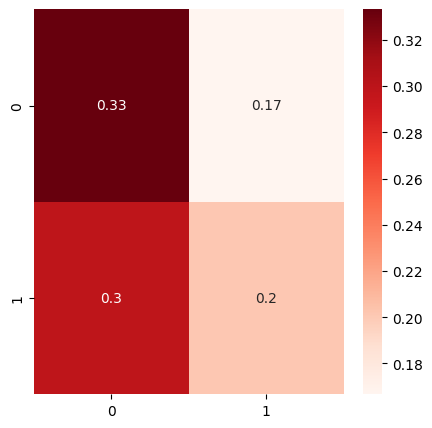

In [198]:
report(y_test, xgb_best.predict(x_test_selected))

### LightGBM

In [199]:
model = LGBMClassifier()

In [200]:
model.fit(
    x_train_selected,
    y_train,
    )

LGBMClassifier()

In [201]:
def param_search_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [202]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(param_search_lgbm, n_trials=30)

[I 2024-11-11 10:35:11,369] A new study created in memory with name: no-name-a9d5713b-1528-4566-9dcf-e7ccc918bc90


[10:35:11] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:11,740] Trial 0 finished with value: 0.3322884012539185 and parameters: {'learning_rate': 0.006781655959727144, 'max_depth': 276, 'n_estimators': 500, 'subsample': 0.13921271431360066, 'colsample_bylevel': 0.22073479005795904, 'gamma': 1.3984152514684742}. Best is trial 0 with value: 0.3322884012539185.


[10:35:11] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:12,239] Trial 1 finished with value: 0.3896848137535816 and parameters: {'learning_rate': 0.003187110483258493, 'max_depth': 496, 'n_estimators': 300, 'subsample': 0.1764961030100558, 'colsample_bylevel': 0.9151551991152105, 'gamma': 1.2902835838961209}. Best is trial 1 with value: 0.3896848137535816.


[10:35:12] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:13,164] Trial 2 finished with value: 0.34782608695652173 and parameters: {'learning_rate': 0.001585723559294967, 'max_depth': 354, 'n_estimators': 700, 'subsample': 0.21830116763603152, 'colsample_bylevel': 0.28271868982862697, 'gamma': 2.869660476363827}. Best is trial 1 with value: 0.3896848137535816.


[10:35:13] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:13,409] Trial 3 finished with value: 0.3227848101265823 and parameters: {'learning_rate': 0.010707309308426057, 'max_depth': 491, 'n_estimators': 200, 'subsample': 0.6735409387422838, 'colsample_bylevel': 0.13136310019438593, 'gamma': 2.808278346749897}. Best is trial 1 with value: 0.3896848137535816.


[10:35:13] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:17,336] Trial 4 finished with value: 0.4148936170212766 and parameters: {'learning_rate': 0.00791686142804315, 'max_depth': 168, 'n_estimators': 700, 'subsample': 0.7640567506374878, 'colsample_bylevel': 0.8525989655589747, 'gamma': 1.7503077837684489}. Best is trial 4 with value: 0.4148936170212766.


[10:35:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:18,255] Trial 5 finished with value: 0.4175824175824176 and parameters: {'learning_rate': 0.013396099490510514, 'max_depth': 348, 'n_estimators': 200, 'subsample': 0.7015787210174683, 'colsample_bylevel': 0.6014141867412719, 'gamma': 2.764554995092727}. Best is trial 5 with value: 0.4175824175824176.


[10:35:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:19,238] Trial 6 finished with value: 0.4034090909090909 and parameters: {'learning_rate': 0.0012691673247477873, 'max_depth': 102, 'n_estimators': 300, 'subsample': 0.5905577688656056, 'colsample_bylevel': 0.4608261147941561, 'gamma': 2.479334029252518}. Best is trial 5 with value: 0.4175824175824176.


[10:35:19] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:20,034] Trial 7 finished with value: 0.41714285714285715 and parameters: {'learning_rate': 0.01444779340543606, 'max_depth': 278, 'n_estimators': 500, 'subsample': 0.16303412789566524, 'colsample_bylevel': 0.6329964866021768, 'gamma': 1.953141165046094}. Best is trial 5 with value: 0.4175824175824176.


[10:35:20] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:22,030] Trial 8 finished with value: 0.40883977900552493 and parameters: {'learning_rate': 0.0011775202815075578, 'max_depth': 491, 'n_estimators': 800, 'subsample': 0.32783258535770615, 'colsample_bylevel': 0.92888221530667, 'gamma': 2.918376396357289}. Best is trial 5 with value: 0.4175824175824176.


[10:35:22] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:22,399] Trial 9 finished with value: 0.4022988505747126 and parameters: {'learning_rate': 0.015303530286895708, 'max_depth': 398, 'n_estimators': 400, 'subsample': 0.05655379866533377, 'colsample_bylevel': 0.8447399976801869, 'gamma': 1.006273944663057}. Best is trial 5 with value: 0.4175824175824176.


[10:35:22] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:23,052] Trial 10 finished with value: 0.3967828418230563 and parameters: {'learning_rate': 0.06375810528820736, 'max_depth': 368, 'n_estimators': 100, 'subsample': 0.9883899268324774, 'colsample_bylevel': 0.6123377142614629, 'gamma': 0.15813039303804}. Best is trial 5 with value: 0.4175824175824176.


[10:35:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:24,572] Trial 11 finished with value: 0.44141689373297005 and parameters: {'learning_rate': 0.031371971382327835, 'max_depth': 257, 'n_estimators': 500, 'subsample': 0.4018784533652998, 'colsample_bylevel': 0.610811225267563, 'gamma': 2.005479754410919}. Best is trial 11 with value: 0.44141689373297005.


[10:35:24] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:27,430] Trial 12 finished with value: 0.45623342175066317 and parameters: {'learning_rate': 0.041860958141773784, 'max_depth': 219, 'n_estimators': 1000, 'subsample': 0.4264749488652279, 'colsample_bylevel': 0.484589149088094, 'gamma': 2.26561514938883}. Best is trial 12 with value: 0.45623342175066317.


[10:35:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:29,908] Trial 13 finished with value: 0.46153846153846156 and parameters: {'learning_rate': 0.05443996661271465, 'max_depth': 210, 'n_estimators': 1000, 'subsample': 0.4039885507390899, 'colsample_bylevel': 0.41411497926078306, 'gamma': 2.171647708625398}. Best is trial 13 with value: 0.46153846153846156.


[10:35:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:32,521] Trial 14 finished with value: 0.451948051948052 and parameters: {'learning_rate': 0.0872891061439243, 'max_depth': 180, 'n_estimators': 1000, 'subsample': 0.45325826383545786, 'colsample_bylevel': 0.4076601520175035, 'gamma': 2.3072052345454126}. Best is trial 13 with value: 0.46153846153846156.


[10:35:32] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:34,317] Trial 15 finished with value: 0.4538258575197889 and parameters: {'learning_rate': 0.03978758283593033, 'max_depth': 210, 'n_estimators': 1000, 'subsample': 0.32963538534828596, 'colsample_bylevel': 0.3079845622597454, 'gamma': 2.249036950860366}. Best is trial 13 with value: 0.46153846153846156.


[10:35:34] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:37,397] Trial 16 finished with value: 0.42021276595744683 and parameters: {'learning_rate': 0.03116663683387053, 'max_depth': 136, 'n_estimators': 900, 'subsample': 0.5102306036921839, 'colsample_bylevel': 0.733696770681687, 'gamma': 0.7940885419949628}. Best is trial 13 with value: 0.46153846153846156.


[10:35:37] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:39,155] Trial 17 finished with value: 0.46875000000000006 and parameters: {'learning_rate': 0.048505075581784046, 'max_depth': 219, 'n_estimators': 800, 'subsample': 0.3389041129020769, 'colsample_bylevel': 0.4214231671716405, 'gamma': 1.72484142230034}. Best is trial 17 with value: 0.46875000000000006.


[10:35:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:39,876] Trial 18 finished with value: 0.4749340369393141 and parameters: {'learning_rate': 0.09714951678156983, 'max_depth': 231, 'n_estimators': 800, 'subsample': 0.2960029718313041, 'colsample_bylevel': 0.07095899921805854, 'gamma': 1.6509621507553072}. Best is trial 18 with value: 0.4749340369393141.


[10:35:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:40,513] Trial 19 finished with value: 0.4574468085106383 and parameters: {'learning_rate': 0.0987507311339401, 'max_depth': 317, 'n_estimators': 700, 'subsample': 0.2932295493637112, 'colsample_bylevel': 0.06436266121888573, 'gamma': 1.686200826504161}. Best is trial 18 with value: 0.4749340369393141.


[10:35:40] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:41,428] Trial 20 finished with value: 0.3701492537313433 and parameters: {'learning_rate': 0.00454954917654, 'max_depth': 234, 'n_estimators': 800, 'subsample': 0.5662343571054453, 'colsample_bylevel': 0.06180293220529226, 'gamma': 0.670518398330054}. Best is trial 18 with value: 0.4749340369393141.


[10:35:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:43,061] Trial 21 finished with value: 0.44908616187989553 and parameters: {'learning_rate': 0.05913406646864367, 'max_depth': 181, 'n_estimators': 900, 'subsample': 0.2696011099627316, 'colsample_bylevel': 0.3717984603799192, 'gamma': 1.240838073275603}. Best is trial 18 with value: 0.4749340369393141.


[10:35:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:43,841] Trial 22 finished with value: 0.43169398907103823 and parameters: {'learning_rate': 0.023846950864097435, 'max_depth': 236, 'n_estimators': 800, 'subsample': 0.34703979925941997, 'colsample_bylevel': 0.22041494198163264, 'gamma': 1.8524523853347323}. Best is trial 18 with value: 0.4749340369393141.


[10:35:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:46,114] Trial 23 finished with value: 0.45430809399477806 and parameters: {'learning_rate': 0.06643454796308546, 'max_depth': 310, 'n_estimators': 900, 'subsample': 0.4382881904081084, 'colsample_bylevel': 0.3609968210293652, 'gamma': 1.532034466373829}. Best is trial 18 with value: 0.4749340369393141.


[10:35:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:47,324] Trial 24 finished with value: 0.4189944134078212 and parameters: {'learning_rate': 0.020350262170190068, 'max_depth': 151, 'n_estimators': 600, 'subsample': 0.24181462509569657, 'colsample_bylevel': 0.526244632802218, 'gamma': 2.0682984427795863}. Best is trial 18 with value: 0.4749340369393141.


[10:35:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:47,868] Trial 25 finished with value: 0.4468085106382979 and parameters: {'learning_rate': 0.04468649934211377, 'max_depth': 205, 'n_estimators': 900, 'subsample': 0.07290555957244249, 'colsample_bylevel': 0.1738349918444477, 'gamma': 2.5487690448133433}. Best is trial 18 with value: 0.4749340369393141.


[10:35:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:49,871] Trial 26 finished with value: 0.446236559139785 and parameters: {'learning_rate': 0.07229630651704898, 'max_depth': 124, 'n_estimators': 600, 'subsample': 0.4869135372920435, 'colsample_bylevel': 0.7282389898690997, 'gamma': 1.5966356337635728}. Best is trial 18 with value: 0.4749340369393141.


[10:35:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:51,452] Trial 27 finished with value: 0.4699738903394256 and parameters: {'learning_rate': 0.050038423667768124, 'max_depth': 258, 'n_estimators': 800, 'subsample': 0.38108166365581414, 'colsample_bylevel': 0.28856635244513773, 'gamma': 2.0811281701223656}. Best is trial 18 with value: 0.4749340369393141.


[10:35:51] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:53,026] Trial 28 finished with value: 0.4751958224543081 and parameters: {'learning_rate': 0.024834523247130456, 'max_depth': 269, 'n_estimators': 800, 'subsample': 0.36321639957040597, 'colsample_bylevel': 0.2817771795051151, 'gamma': 1.167668475387816}. Best is trial 28 with value: 0.4751958224543081.


[10:35:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 10:35:54,572] Trial 29 finished with value: 0.4289544235924933 and parameters: {'learning_rate': 0.027691071203283808, 'max_depth': 279, 'n_estimators': 600, 'subsample': 0.5585115707289898, 'colsample_bylevel': 0.2584085825271816, 'gamma': 1.0807042798803026}. Best is trial 28 with value: 0.4751958224543081.


In [203]:
print('Best hyperparameters:', study_lgbm.best_params)
print('Best f1 score:', study_lgbm.best_value)

Best hyperparameters: {'learning_rate': 0.024834523247130456, 'max_depth': 269, 'n_estimators': 800, 'subsample': 0.36321639957040597, 'colsample_bylevel': 0.2817771795051151, 'gamma': 1.167668475387816}
Best f1 score: 0.4751958224543081


In [204]:
lgbm_best = LGBMClassifier(learning_rate=study_lgbm.best_params['learning_rate'],
                             max_depth=study_lgbm.best_params['max_depth'],
                             n_estimators = study_lgbm.best_params['n_estimators'],
                             random_seed=42,
                             subsample=study_lgbm.best_params['subsample'])
lgbm_best.fit(x_train_selected, y_train)

LGBMClassifier(learning_rate=0.024834523247130456, max_depth=269,
               n_estimators=800, random_seed=42, subsample=0.36321639957040597)

In [205]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(lgbm_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([0.52406073, 0.57553077, 0.57418561, 0.57036424, 0.5673151 ]),
 'score_time': array([0.02046394, 0.02107501, 0.02042031, 0.02246523, 0.0213654 ]),
 'test_accuracy': array([0.70816327, 0.6755102 , 0.6755102 , 0.65510204, 0.61632653]),
 'test_precision_macro': array([0.76752504, 0.61197917, 0.61748634, 0.61978282, 0.60268344]),
 'test_recall_macro': array([0.55685079, 0.58660624, 0.60131296, 0.62869331, 0.6163332 ]),
 'test_f1_macro': array([0.5195782 , 0.58881119, 0.60502101, 0.6220016 , 0.59749021]),
 'test_roc_auc': array([0.77023124, 0.71620209, 0.70641661, 0.6796063 , 0.69015182])}

In [206]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
lgbm_best_cv_metrics = []
for metric in metrics: lgbm_best_cv_metrics.append(scores[metric])
lgbm_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
lgbm_best_cv_metrics = np.array(lgbm_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.50      0.64      0.56       216
           1       0.50      0.36      0.42       216

    accuracy                           0.50       432
   macro avg       0.50      0.50      0.49       432
weighted avg       0.50      0.50      0.49       432

F2-score:  0.3781925343811395


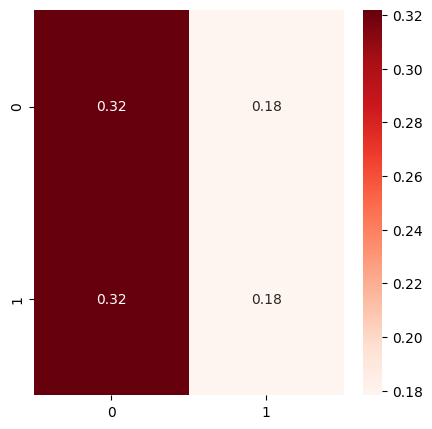

In [207]:
report(y_test, lgbm_best.predict(x_test_selected))

# Результаты

In [208]:
best_models = [rfc_best, xgb_rfc_best, xgb_best, lgbm_best, cb_best]

In [209]:
best_models_cv_metrics = [rfc_best_cv_metrics, xgb_rfc_best_cv_metrics, xgb_best_cv_metrics, lgbm_best_cv_metrics, cb_best_cv_metrics]

In [210]:
def test_results(model, x_test, y_true):
  y_pred = model.predict(x_test)
  round_num = 2
  result_dict = {
      "Accuracy": round(accuracy_score(y_true, y_pred), round_num),
      "AUC": round(roc_auc_score(y_true, y_pred), round_num),
      "Precision": round(precision_score(y_true, y_pred), round_num),
      "Recall": round(recall_score(y_true, y_pred), round_num),
      "F1-score": round(f1_score(y_true, y_pred), round_num),
      "F2-score": round(f2_score(y_true, y_pred), round_num)
  }
  return result_dict

In [211]:
round_num = 2
for metrics in best_models_cv_metrics:
  print("'Accuracy':", round(np.mean(metrics[0]), round_num),"+-",round(np.std(metrics[0]), round_num),",",
        "'AUC':", round(np.mean(metrics[1]), round_num),"+-",round(np.std(metrics[1]), round_num),","
        "'Precision':", round(np.mean(metrics[2]), round_num),"+-",round(np.std(metrics[2]), round_num),","
        "'Recall':", round(np.mean(metrics[3]), round_num),"+-",round(np.std(metrics[3]), round_num),","
        "'F1-score':", round(np.mean(metrics[4]), round_num),"+-",round(np.std(metrics[4]), round_num),","
        "'F2-score':", round(np.mean(metrics[5]), round_num),"+-",round(np.std(metrics[5]), round_num),)

'Accuracy': 0.79 +- 0.03 , 'AUC': 0.87 +- 0.03 ,'Precision': 0.79 +- 0.04 ,'Recall': 0.73 +- 0.07 ,'F1-score': 0.73 +- 0.08 ,'F2-score': 0.74 +- 0.06
'Accuracy': 0.7 +- 0.02 , 'AUC': 0.76 +- 0.04 ,'Precision': 0.7 +- 0.08 ,'Recall': 0.61 +- 0.03 ,'F1-score': 0.6 +- 0.03 ,'F2-score': 0.62 +- 0.02
'Accuracy': 0.69 +- 0.04 , 'AUC': 0.74 +- 0.05 ,'Precision': 0.68 +- 0.06 ,'Recall': 0.62 +- 0.03 ,'F1-score': 0.61 +- 0.03 ,'F2-score': 0.63 +- 0.02
'Accuracy': 0.67 +- 0.03 , 'AUC': 0.71 +- 0.03 ,'Precision': 0.64 +- 0.06 ,'Recall': 0.6 +- 0.02 ,'F1-score': 0.59 +- 0.04 ,'F2-score': 0.61 +- 0.01
'Accuracy': 0.68 +- 0.03 , 'AUC': 0.72 +- 0.04 ,'Precision': 0.66 +- 0.05 ,'Recall': 0.61 +- 0.03 ,'F1-score': 0.61 +- 0.03 ,'F2-score': 0.62 +- 0.02


In [212]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_test_imp, y_test))
  else: print(test_results(model, x_test_selected, y_test))

{'Accuracy': 0.6, 'AUC': 0.6, 'Precision': 0.69, 'Recall': 0.35, 'F1-score': 0.47, 'F2-score': 0.39}
{'Accuracy': 0.52, 'AUC': 0.52, 'Precision': 0.53, 'Recall': 0.36, 'F1-score': 0.43, 'F2-score': 0.38}
{'Accuracy': 0.53, 'AUC': 0.53, 'Precision': 0.55, 'Recall': 0.4, 'F1-score': 0.46, 'F2-score': 0.43}
{'Accuracy': 0.5, 'AUC': 0.5, 'Precision': 0.5, 'Recall': 0.36, 'F1-score': 0.42, 'F2-score': 0.38}
{'Accuracy': 0.52, 'AUC': 0.52, 'Precision': 0.53, 'Recall': 0.41, 'F1-score': 0.46, 'F2-score': 0.43}


In [213]:
import shap
shap.initjs()

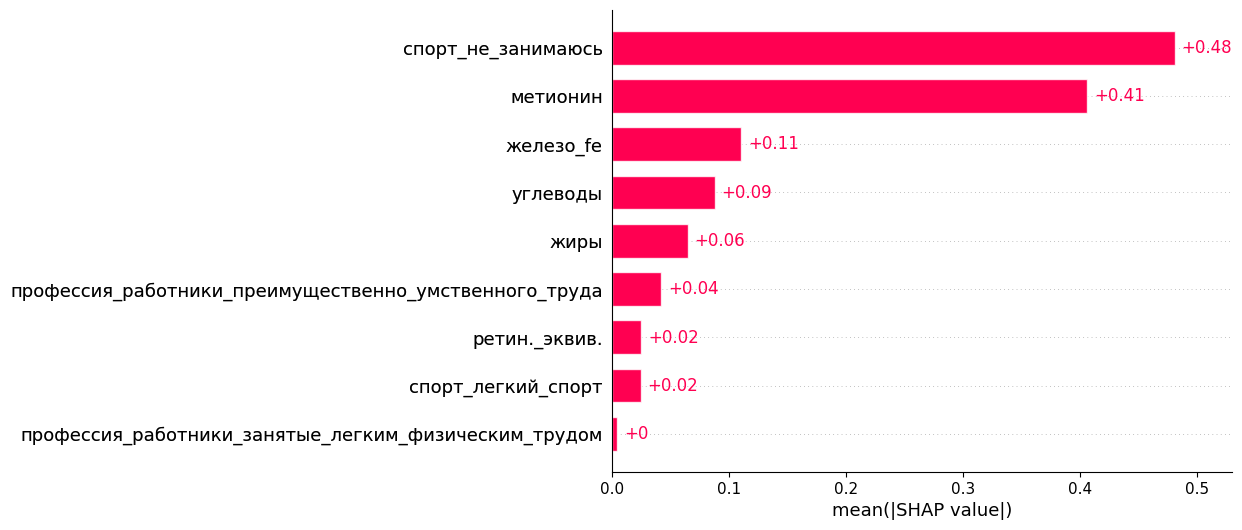

In [214]:
explainer = shap.TreeExplainer(xgb_rfc_best)
shap_values = explainer(x_train_selected)
shap.plots.bar(shap_values)